In [1]:
import json
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# **DATASETS PREPROCESSING**

* * *

## **URLs DATASET**

In [2]:
# import urls dataset
urls = pd.read_csv('DATASETS/INIT/URLS.csv')
# mapping 0 to 1 for phishing, and 1 to 0 for benign samples
urls['status'] = urls['status'].map({0: 1, 1: 0})
# renaming column to maintain uniformity
urls.rename(columns={'status': 'label', 'url': 'text'}, inplace=True)
# shuffling rows due to dataset structure
urls = urls.sample(frac=1).reset_index(drop=True)
urls

,text,label
0,mccartenviolins.com,1
1,https://gtrfdfsd.dsmtp.com/,1
2,91.239.25.121:6892,1
3,nsecoaching.ca/cd62kg4btm,1
4,footballfanatics.com/MLB_Kansas_City_Royals,0
...,...,...
822005,far.PREPHANLAW.COM/?q=w33QMvXcJxnQFYbGMvnDSKNb...,1
822006,loglar.com/album.php?id=2652,0
822007,businessweek.com/globalbiz/blog/eyeonasia/arch...,0
822008,outpersonals.com/geozones/gaymen/United_States...,0


#### Missing and Duplicated Values

In [3]:
print(f"There are missing values?: {urls.isna().any().any()}")
print(f"There are duplicated URLs?: {urls['text'].duplicated().any()}")
print(f"There are empty strings in url column?: {urls.where(urls['text'] == '').any().any()}")

There are missing values?: False
There are duplicated URLs?: True
There are empty strings in url column?: False


In [4]:
# Solving duplicates
urls = urls.drop_duplicates(subset=['text'])
urls.reset_index(drop=True, inplace=True)
print(f"URL dataset shape: {urls.shape}")

URL dataset shape: (808042, 2)


#### Balance Dataset

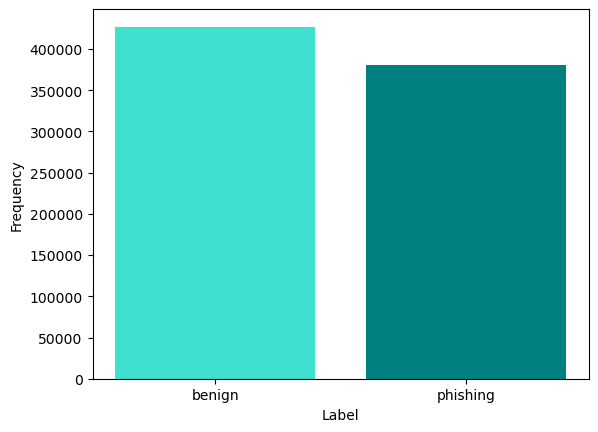

label
0    427028
1    381014
Name: count, dtype: int64


In [5]:
url_label_counts = urls['label'].value_counts()
plt.bar(['benign', 'phishing'], url_label_counts, color=['turquoise', 'teal'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
print(url_label_counts)

We have 427028 benign samples and 381014 phishing samples. That means that the proportions are: 
- 52.8% benign
- 47.1% phishing

The dataset is balanced.

* * *

## **EMAILS DATASET**

In [6]:
# importing emails dataset
emails = pd.read_csv('DATASETS/INIT/EMAILS.csv', index_col=0)
# renaming columns to maintain uniformity
emails.rename(columns={'Email Text': 'text', 'Email Type': 'label'}, inplace=True)
# mapping label values to 1 (phishing) and 0s (benign)
emails['label'] = emails['label'].map({'Phishing Email': 1, 'Safe Email': 0})
emails

,text,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1
...,...,...
18646,date a lonely housewife always wanted to date ...,1
18647,request submitted : access request for anita ....,0
18648,"re : important - prc mtg hi dorn & john , as y...",0
18649,press clippings - letter on californian utilit...,0


#### Missing and Duplicated Values

In [7]:
print(f"There are missing values?: {emails.isna().any().any()}")
print(f"There are duplicated emails?: {emails['text'].duplicated().any()}")
print(f"There are empty strings in text column?: {emails.where(emails['text'] == '').any().any()}")

There are missing values?: True
There are duplicated emails?: True
There are empty strings in text column?: False


In [8]:
# Solving duplicated and missing values
emails = emails.drop_duplicates(subset=['text']) 
emails = emails.dropna(how='any',axis=0) 
emails = emails[emails['text'] != 'empty'] 
emails.reset_index(drop=True, inplace=True)
print(f"Emails dataset shape: {emails.shape}")

Emails dataset shape: (17536, 2)


#### Balance Dataset 

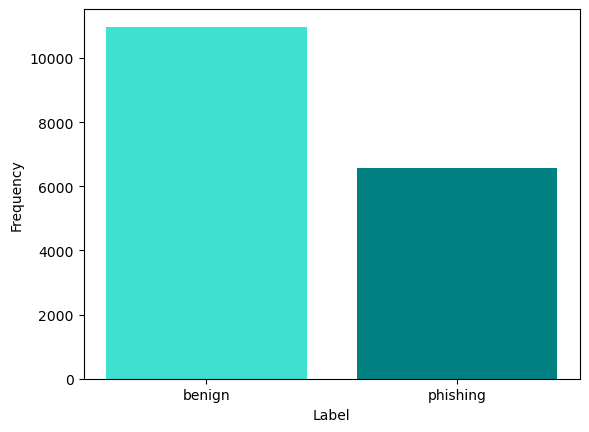

label
0    10979
1     6557
Name: count, dtype: int64


In [9]:
email_label_counts = emails['label'].value_counts()
plt.bar(['benign', 'phishing'], email_label_counts, color=['turquoise', 'teal'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
print(email_label_counts)

We have 10979 benign samples and 6557 phishing samples. That means that the proportions are: 
- 62.6% benign
- 37.4% phishing

There is no significant difference between classes proportion, so we can continue

* * *

## **SMS DATASET**

In [10]:
# import sms dataset
sms = pd.read_csv('DATASETS/INIT/SMS.csv')
# rename, dropping and moving columns to maintain uniformity
sms.rename(columns={'LABEL': 'label', 'TEXT': 'text'}, inplace=True)
sms.drop(['EMAIL', 'PHONE', 'URL'], axis=1, inplace=True)
sms = sms.assign(label=sms.pop('label'))
# mapping label values to 1 (phishing) and 0s (benign)
sms['label'] = (sms['label'].str.lower()).map({'ham': 0, 'smishing': 1, 'spam': 1})
sms

,text,label
0,Your opinion about me? 1. Over 2. Jada 3. Kusr...,0
1,What's up? Do you want me to come online? If y...,0
2,So u workin overtime nigpun?,0
3,"Also sir, i sent you an email about how to log...",0
4,Please Stay At Home. To encourage the notion o...,1
...,...,...
5966,:( but your not here....,0
5967,Becoz its &lt;#&gt; jan whn al the post ofic...,0
5968,Its a valentine game. . . send dis msg to all ...,0
5969,We r outside already.,0


#### Missing and Duplicate Values

In [11]:
print(f"There are missing values?: {sms.isnull().any().any()}")
print(f"There are duplicated sms?: {sms['text'].duplicated().any()}")
print(f"There are empty strings in text column?: {sms.where(sms['text'] == '').any().any()}")

There are missing values?: False
There are duplicated sms?: True
There are empty strings in text column?: False


In [12]:
# Solving duplicates
sms = sms.drop_duplicates(subset=['text'])
sms.reset_index(drop=True, inplace=True)
print(f"SMS dataset shape: {sms.shape}")

SMS dataset shape: (5949, 2)


#### Balance Dataset

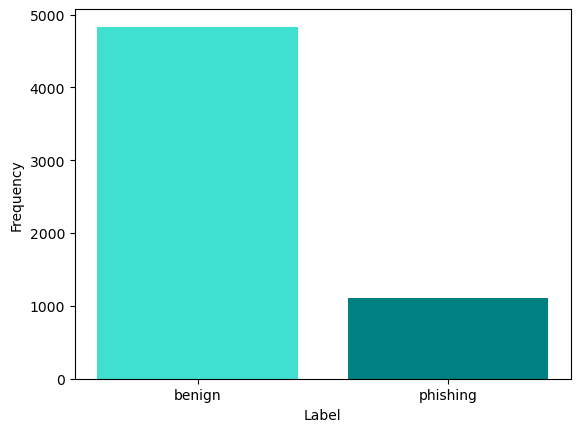

label
0    4834
1    1115
Name: count, dtype: int64


In [13]:
sms_label_counts = sms['label'].value_counts()
plt.bar(['benign', 'phishing'], sms_label_counts, color=['turquoise', 'teal'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
print(sms_label_counts)

We have 4834 benign samples and 1115 phishing samples. That means that the proportions are: 
- 81.2% benign
- 18.7% phishing

There is a significant difference between classes proportion. This is an unbalanced dataset

We have an unbalanced dataset, with many more benign SMS messages than malicious ones. If we want to eliminate some benign samples in order to balance the dataset it we can use the **undersampling** method. This method consists in to reduce the number of observations of the majority class (in this case, the benign SMS) 
until it is equal to the number of observations of the minority class (in this case, the malignant SMS).

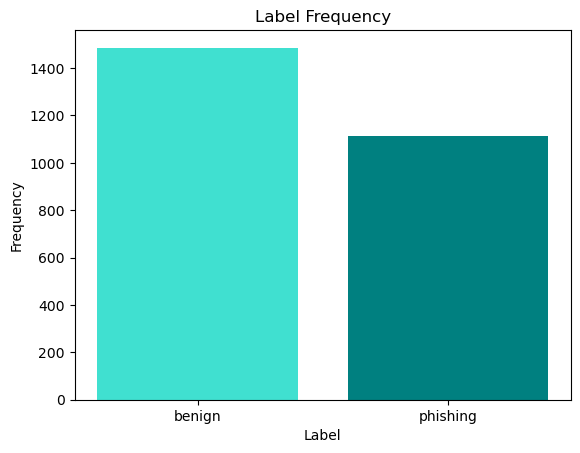

label
0    1486
1    1115
Name: count, dtype: int64


In [14]:
# calculate the size of the minority class
sms_minority_size = sms[sms['label'] == 1].shape[0]

# randomly select a subset of observations from the majority class
sms_majority_subset = sms[sms['label'] == 0].sample(
    n=sms_minority_size+(sms_minority_size//3),
    replace=False)

# combine the minority and majority subsets to create a new, balanced dataset
sms = pd.concat([sms_majority_subset, sms[sms['label'] == 1]])
sms.reset_index(drop=True, inplace=True)

sms_label_counts = sms['label'].value_counts()
plt.bar(['benign', 'phishing'], sms_label_counts, color=['turquoise', 'teal'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Frequency')
plt.show()
print(sms_label_counts)

* * *

## **WEBSITES DATASET**

In [15]:
# we have to create a database to get html files
conn = sqlite3.connect(Path("~/Documents/WEBSITES/websites.db").expanduser())

# open and read index.sql, where html files are
with open(Path("~/Documents/WEBSITES/index.sql").expanduser(), "r") as f:
    sql = f.read()

sql = sql.replace("`", "'")
conn.executescript(sql)
conn.commit()

# read table data and pass it to a pandas dataframe
webs = pd.read_sql_query("SELECT * FROM \"index\" LIMIT 30000", conn)

conn.close()

webs.drop(['rec_id', 'created_date'], inplace=True, axis=1)
webs.rename(columns={'website': 'text', 'result': 'label'}, inplace=True)
webs

,url,text,label
0,http://intego3.info/EXEL/index.php,1613573972338075.html,1
1,https://www.mathopenref.com/segment.html,1635698138155948.html,0
2,https://www.computerhope.com/issues/ch000254.htm,1635699228889266.html,0
3,https://www.investopedia.com/terms/n/next-elev...,1635750062162701.html,0
4,https://jobs.emss.org.uk/lcc.aspx,161356510250721.html,0
...,...,...,...
29995,http://neuropathyhealthcenter.com/neuropathy-p...,1635710574719465.html,0
29996,http://forever-inject-onlinestore-com.sell.eve...,1613583393590779.html,0
29997,https://www.yourdictionary.com/hopper,1635714045723937.html,0
29998,https://linktr.ee/btonlinecustomerservice,10003100.html,1


#### HTML Codes Extraction

It's worthwhile to analyze the websites dataset. Nevertheless, processing each HTML code sample could be pretty heavy and delayed. That's why is necessary to filter those HTML samples that exceed a SIZE threshold. On this case, we decided the threshold to be: **100 KB**. Also, we can speed HTML extraction from disk by executing the code using Cython library. Cython compile python code in C, and this increases the performance significantly.

In [16]:
%load_ext cython

In [17]:
%%cython
import os

MAX_FILE_SIZE = 100 # max file size in KB

prefix = os.path.expanduser("~/Documents/WEBSITES/DATASET/") # common prefix where HTML codes are stored
html_directories = [
    "dataset-part-1/", 
    "dataset-part-2/",
    "dataset-part-3/",
    "dataset-part-4/",
    "dataset-part-5/",
    "dataset-part-6/",
    "dataset-part-7/",
    "dataset-part-8/"]

def B_TO_KB(b):
    kilobytes = b / 1024
    return kilobytes

def get_html(filename):
    
    for directory in html_directories:
        dir_path = os.path.join(prefix, directory)
        files = os.listdir(dir_path)
        for file in files:
            if file == filename:
                html_path = os.path.join(dir_path, file)
                break
            
    if B_TO_KB(os.path.getsize(html_path)) <= MAX_FILE_SIZE:
        with open(html_path, 'r') as html_file:
            html = html_file.read()
        return html
    else:
        return None

In [18]:
# retrieve html codes from disk
webs['text'] = webs['text'].parallel_map(lambda file: get_html(file))
# drop those samples where html text is None, because they were too heavy
webs = webs[webs.text.notnull()]
# reset indexes after drop
webs.reset_index(drop=True, inplace=True)
# print resulting webs dataset shape
print(f"Webs dataset shape: {webs.shape}")
webs

Webs dataset shape: (20887, 3)


,url,text,label
0,http://intego3.info/EXEL/index.php,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",1
1,https://www.mathopenref.com/segment.html,<!DOCTYPE html>\n<html>\n <head>\n <title>\n ...,0
2,https://www.computerhope.com/issues/ch000254.htm,<!DOCTYPE html>\n<!--[if lt IE 7]><html class=...,0
3,https://jobs.emss.org.uk/lcc.aspx,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",0
4,http://www.pracspedia.com/INS/one-time-passwor...,<html>\n <head>\n <title>\n Not Acceptable!...,0
...,...,...,...
20882,https://www.pasthorizonstools.com/,<!DOCTYPE html>\n<!--[if lt IE 7]><html class=...,0
20883,http://neuropathyhealthcenter.com/neuropathy-p...,<html>\n <head>\n <title>\n Loading...\n <...,0
20884,http://forever-inject-onlinestore-com.sell.eve...,<!DOCTYPE html>\n<html>\n <head>\n <meta cont...,0
20885,https://linktr.ee/btonlinecustomerservice,"<html><head><meta name=""viewport"" content=""wid...",1


#### Missing and Duplicated Values

In [19]:
print(f"There are missing values?: {webs.isna().any().any()}")
print(f"There are duplicated webs?: {webs['text'].duplicated().any()}")
print(f"There are empty strings in text column?: {webs.where(webs['text'] == '').any().any()}")

There are missing values?: False
There are duplicated webs?: True
There are empty strings in text column?: False


In [20]:
# Solving duplicates
webs = webs.drop_duplicates(subset=['text'])
webs.reset_index(drop=True, inplace=True)
print(f"Webs dataset shape: {webs.shape}")

Webs dataset shape: (15756, 3)


#### Balance Dataset

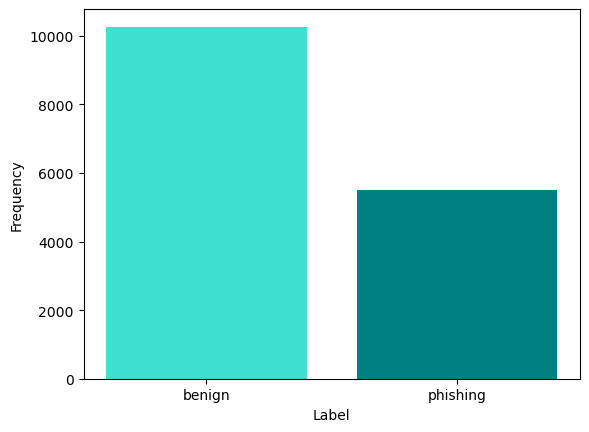

label
0    10264
1     5492
Name: count, dtype: int64


In [21]:
web_label_counts = webs['label'].value_counts()
plt.bar(['benign', 'phishing'], web_label_counts, color=['turquoise', 'teal'])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
print(web_label_counts)

We have 10264 benign samples and 5492 phishing samples. That means that the proportions are: 
- 65.1% benign
- 34.8% phishing

There is no significant difference between classes proportion, so we can continue

#### URLs Extraction

Before deleting the URL column of this dataset to keep only the text, we can take advantage of these new URLs to add them to the URL dataset and increase their number of samples.

In [22]:
# add urls to URLs dataframe
urls_added = 0
for index in webs[~webs['url'].isnull()].index:
    row = webs.iloc[index]
    data = {'text': row['url'], 'label': row['label']}
    urls = pd.concat([urls, pd.DataFrame([data])], axis=0, ignore_index=True)
    urls_added += 1
webs.drop(['url'], axis=1, inplace=True)

# print new urls added
print(f"New URLs added (+{urls_added}):\n")
urls

New URLs added (+15756):



/var/folders/bf/74p6fnsx6v582xb04v67qg4r0000gn/T/ipykernel_9269/2329777480.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  webs.drop(['url'], axis=1, inplace=True)


,text,label
0,mccartenviolins.com,1
1,https://gtrfdfsd.dsmtp.com/,1
2,91.239.25.121:6892,1
3,nsecoaching.ca/cd62kg4btm,1
4,footballfanatics.com/MLB_Kansas_City_Royals,0
...,...,...
823793,https://www.pasthorizonstools.com/,0
823794,http://neuropathyhealthcenter.com/neuropathy-p...,0
823795,http://forever-inject-onlinestore-com.sell.eve...,0
823796,https://linktr.ee/btonlinecustomerservice,1


In [23]:
webs.to_csv('DATASETS/INIT/WEBS.csv', index=False)

#### Minification ✏️

Minification is a process that consists of removing unnecessary characters from the code, without changing its functionality. This optimization of the HTML code reduces waiting times by allowing fast reading of the data by the models.

In [24]:
%%cython
import minify_html

def minify(html):
    return minify_html.minify(html)

In [25]:
# minifying html texts to improve training speed
webs['text'] = webs['text'].parallel_map(lambda html: minify(html))
webs

/var/folders/bf/74p6fnsx6v582xb04v67qg4r0000gn/T/ipykernel_9269/1300765979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  webs['text'] = webs['text'].parallel_map(lambda html: minify(html))


,text,label
0,"<!doctypehtml PUBLIC ""-//W3C//DTD HTML 4.01 Tr...",1
1,<!doctypehtml><title>\n Segment - Math Open ...,0
2,<!doctypehtml><html itemscope itemtype=http://...,0
3,"<!doctypehtml PUBLIC ""-//W3C//DTD XHTML 1.0 Tr...",0
4,<title>\n Not Acceptable!\n </title><body><...,0
...,...,...
15751,<!doctypehtml><html class=no-js><meta content=...,0
15752,<title>\n Loading...\n </title><body><scrip...,0
15753,<!doctypehtml><meta content=IE=7 http-equiv=X-...,0
15754,<meta content=width=device-width name=viewport...,1


* * *

## **COMBINED DATASET**

Before unifying all the datasets, we noticed that there are too many URLs samples compared to the mails, sms and html samples. Therefore, we will only keep 5% of the urls samples to prevent the ML model from ignoring the minority samples; resulting in poor generalization and performance.

In [26]:
# splitting the 5% of samples with stratification
reduced_urls, _ = train_test_split(urls, test_size=0.95, stratify=urls['label'])

Finally, we can combine all datasets we've preprocessed in a single dataset that stores: URLs, Emails, SMS and HTML codes. Great!

In [27]:
combined = pd.concat([reduced_urls, emails, sms, webs], axis=0, ignore_index=True)
combined = combined.sample(frac=1).reset_index(drop=True)
combined

,text,label
0,hi paliourg all pills here . get it all . busi...,1
1,URL: http://www.askbjoernhansen.com/archives/2...,0
2,newsweek : u . s visa regulations dreaming of ...,1
3,start date : 1 / 30 / 02 ; hourahead hour : 11...,0
4,"swordstick \ / 1 aagrra . xaanax , \ / alilum ...",1
...,...,...
77077,"<meta content=""text/html; charset=utf-8""http-e...",1
77078,http://inbox011.com/,1
77079,abebooks.com/book-search/author/stevenson-robe...,0
77080,https://app.datum.org/,0


Then, we'll split dataset in training and test subsets

In [28]:
train_combined, test_combined = train_test_split(combined, test_size=0.2, stratify=combined['label'])
train_combined

,text,label
31528,https://www.a10.com/multiplayer-games,0
20296,matthewpryor.com/,0
42094,<!doctypehtml><title>\n Hopper - definition ...,0
45174,mylife.com/c-1509246489,0
30742,http://printerstudent.com/ssl/cmd-login=7b7adf...,1
...,...,...
76767,"( no subject ) stinson , henwood can help us w...",0
34646,http://yourdreamtv.com.ng/ok/protected/index.html,1
14025,nipple-hypochlorite.com,1
72402,https://vlkkkeb.asia/index.php?id=,1


The resulting datasets we can export them as JSON files for further use in Hugging Face

In [29]:
def df_to_json(df: pd.DataFrame, filename: str):
    
    df_json = []
    for row in df.itertuples():
        df_json.append(
            {
                "text": row.text,
                "label": row.label
            }
        )
    with open(f"DATASETS/FINAL/{filename}.json", "w", encoding='utf-8') as f:
        json.dump(df_json, f, indent=2)

In [30]:
df_to_json(train_combined, 'train')
df_to_json(test_combined, 'test')

* * *

## **SAVE DATASETS**

Now that we have finished the preprocessing, we will save the datasets for use with classification models. We will also combine the mail and sms dataset into one dataset which will be for text.

In [31]:
texts = pd.concat([emails, sms], axis=0, ignore_index=True)

In [32]:
urls.to_csv('DATASETS/PRE/URLS.csv', index=False)
webs.to_csv('DATASETS/PRE/WEBS.csv', index=False)
texts.to_csv('DATASETS/PRE/TEXTS.csv', index=False)